In [1]:
import itertools
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
from scipy.interpolate import RBFInterpolator

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In this notebook, I create a simple Gaussian function that diffuses as a 
function of time and use reduced-order models to make predictions. 
The analytic function is given by:

\begin{align*}
f(x,t)=\frac{T_{max}}{\sqrt{1+4t\kappa/\sigma^2}}\exp\left(\frac{-x^2}{\sigma^2+4t\kappa}\right)
\end{align*}

In [2]:
tmax = 1.0
kappa = 1.0
sigma = 1.0

def gauss(x, t):
    return tmax/np.sqrt(1+4*t*kappa/sigma**2)*np.exp(
        -x**2/(sigma**2+4*t*kappa))

To test the ROM accuracy, we will evaluate the ROM over a grid of 1000 points
to obtain the analytic solution (shown below).

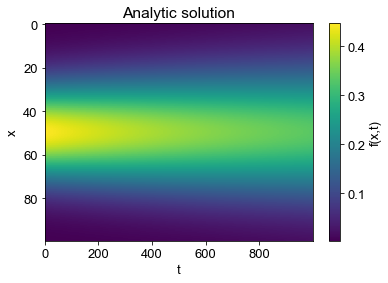

In [3]:
# Bounds for the parameters (t, Tmax, kappa, sigma)
l_bound = [1]
u_bound = [2]
dim = len(l_bound)

ntruth = 1000

x = np.linspace(-5, 5, 100)

# Generate test grid for error evaluation
Ptruth = np.linspace(l_bound, u_bound, ntruth)
Ptruth_stacked = np.array(list(itertools.product(*Ptruth.T)))

truth = np.array([gauss(x, *param) for param in Ptruth_stacked]).T

plt.imshow(truth, aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar(label='f(x,t)')
plt.title('Analytic solution')
plt.show()

To build the ROM, I draw 50 samples with a Halton distribution, obtain the analytic results, then perform a singular value decomposition.

In [4]:
nsamples = 50
sampler = qmc.Halton(d=dim, seed=0)
P = qmc.scale(sampler.random(n=nsamples), l_bound, u_bound)
data = np.array([gauss(x, *param) for param in P]).T
u, s, vh = np.linalg.svd(data)

We can then determine the rank by looking at the singular values.

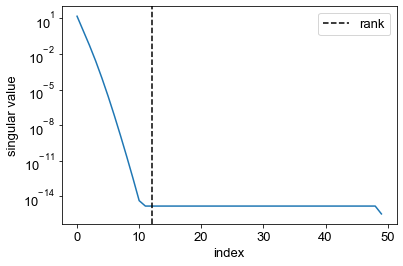

In [5]:
rank = 12
u_rank = u[:, 0:rank]

plt.plot(s)
plt.xlabel('index')
plt.ylabel('singular value')
plt.axvline(rank, ls='--', c='k', label='rank')
plt.yscale('log')
plt.legend()
plt.show()

I then calculate the POD coefficients, standardize the inputs/outputs (mean 0, variance 1), and run a series of regressions (neural network, decision tree, k-nearest neighbors, gaussian process regressor, and RBF) to find the best interpolation for the POD coefficients. For each regressor, I compare the predicted solution with the analytic solution. I also plot the interpolations for each of the POD coefficients (modes).

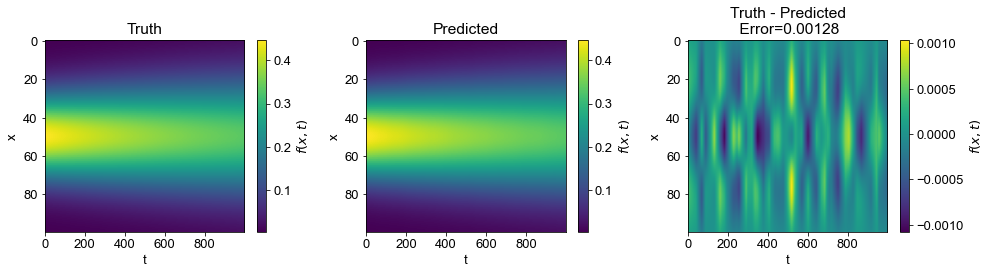

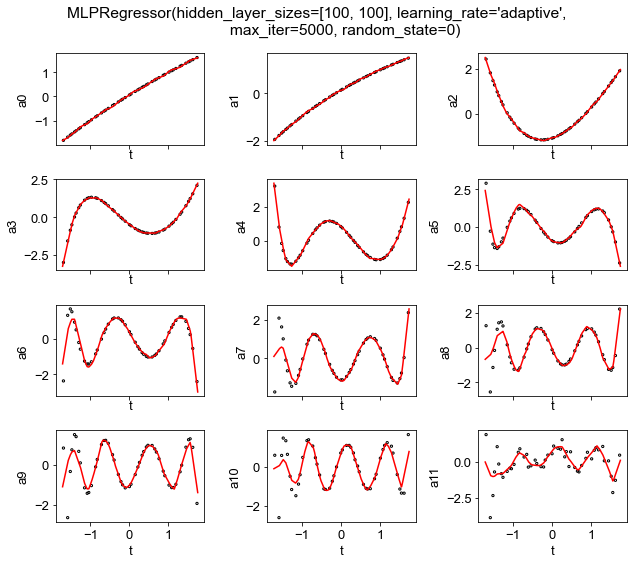

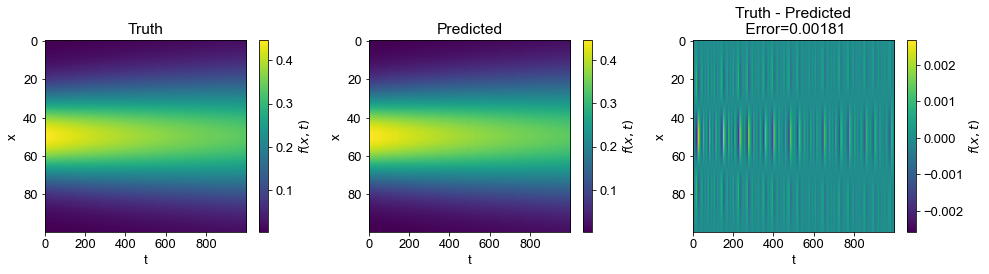

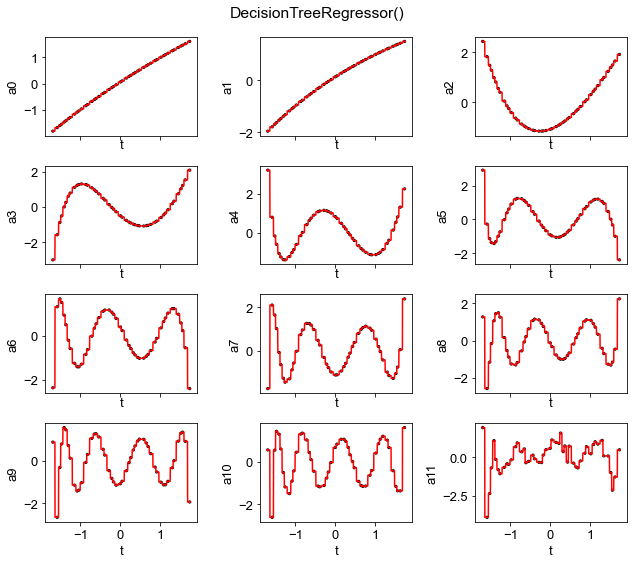

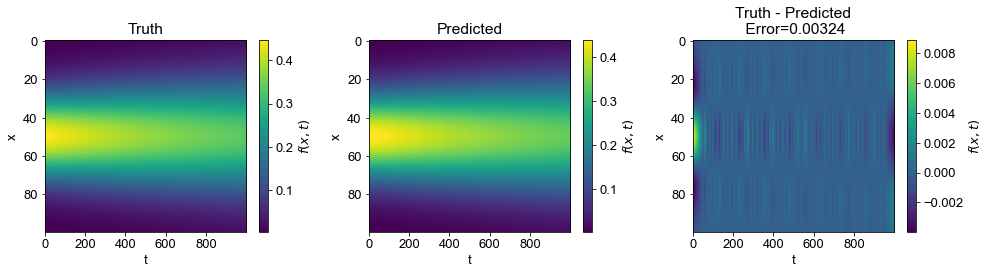

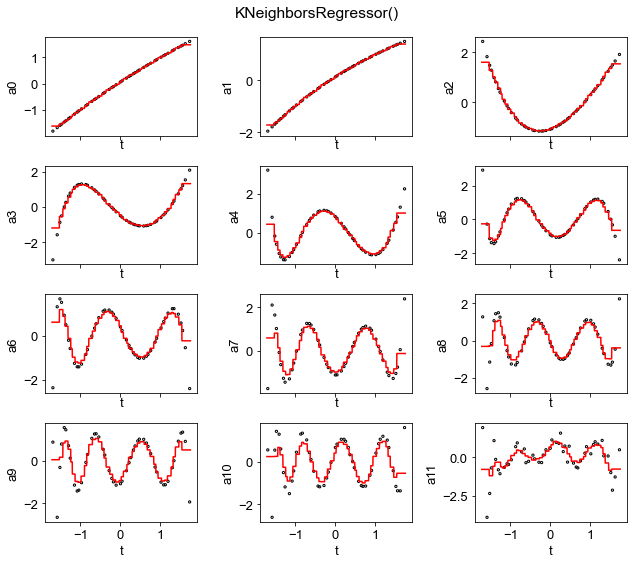

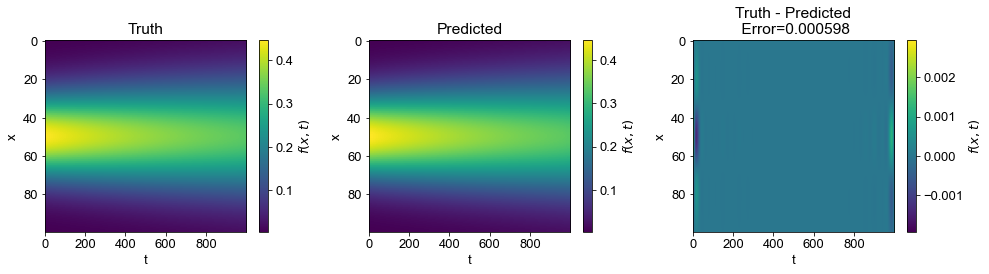

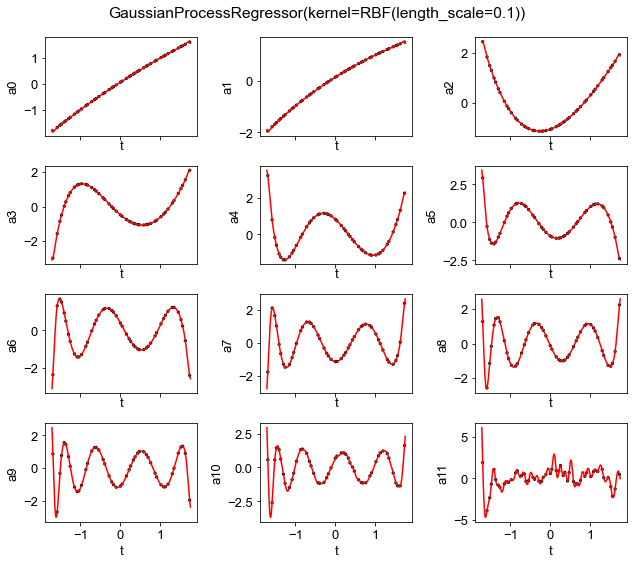

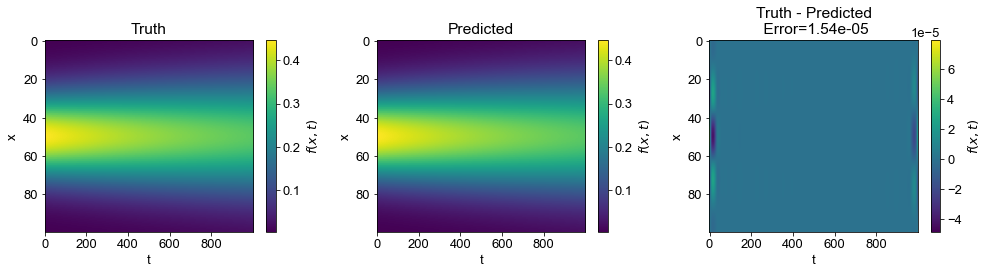

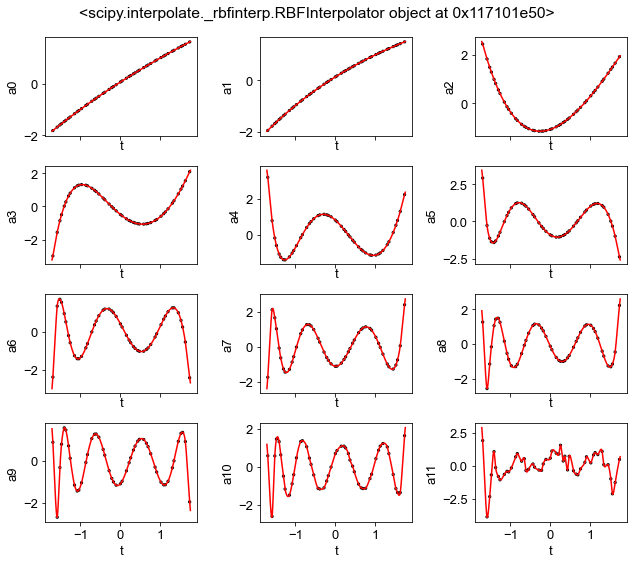

In [6]:
# Calculate and normalize the POD coefficients
A = data.T @ u_rank
Pscaler = preprocessing.StandardScaler().fit(P)
Ascaler = preprocessing.StandardScaler().fit(A)

A_scaled = Ascaler.transform(A)
P_scaled = Pscaler.transform(P)

regressors = [
    MLPRegressor(
        hidden_layer_sizes=[100, 100],
        random_state=0,
        learning_rate='adaptive',
        max_iter=5000),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GaussianProcessRegressor(kernel=RBF(0.1, 'fixed')),
    RBFInterpolator(P_scaled, A_scaled)
]

Ptruth_trans_stacked = Pscaler.transform(Ptruth_stacked)

for regr in regressors:
    try:
        regr.fit(P_scaled, A_scaled)
        Apred = regr.predict(Ptruth_trans_stacked)
    except AttributeError:
        Apred = regr(Ptruth_trans_stacked)
    pred = u_rank @ Ascaler.inverse_transform(Apred).T
    error = np.linalg.norm(truth - pred) / np.linalg.norm(truth)
    arrs = [truth, pred, truth - pred]
    titles = ['Truth', 'Predicted', 'Truth - Predicted\n Error=%.3g' % error]
    plt.figure(figsize=(14, 4))
    for i, arr in enumerate(arrs):
        plt.subplot(1, len(arrs), i+1)
        plt.imshow(arr, aspect='auto')
        plt.colorbar(label='$f(x,t)$')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

    # Look at mode interpolations
    fig, axes = plt.subplots(
        nrows=4, ncols=3, figsize=(9, 8), sharex=True)
    axes = axes.flatten()
    for i in range(len(axes)):
        ax = axes[i]
        ax.scatter(P_scaled, A_scaled.T[i], s=5, edgecolors='k', facecolors='none')
        ax.plot(Ptruth_trans_stacked, Apred.T[i], c='r')
        ax.set_xlabel('t')
        ax.set_ylabel('a%s' % i)
    plt.suptitle(str(regr))
    plt.tight_layout()
    plt.show()

To show the importance of standardizing the inputs/outputs before training the regressors, I show the performance of the neural network regressor with non-standardized inputs/outputs.

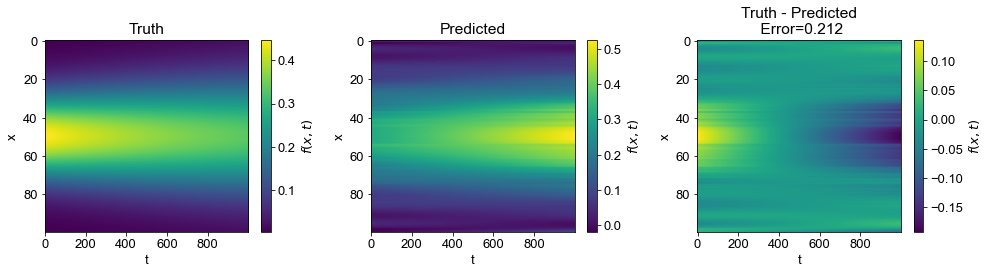

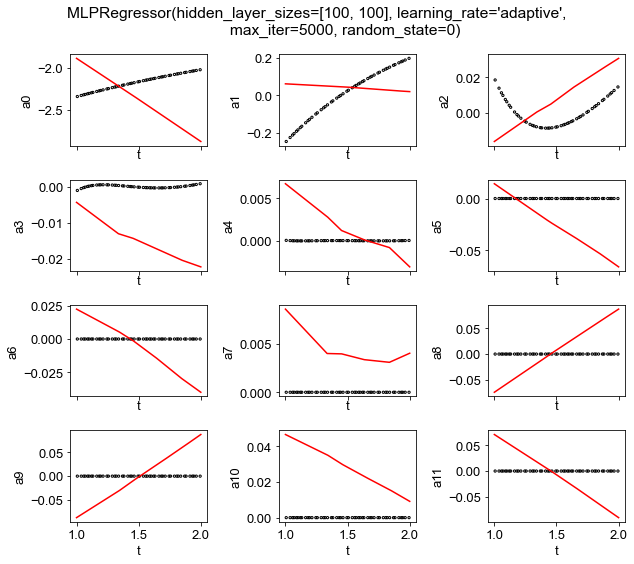

In [7]:
# Compare against neural network regressor without standardizing the
# inputs/outputs before training
regr = MLPRegressor(
        hidden_layer_sizes=[100, 100],
        random_state=0,
        learning_rate='adaptive',
        max_iter=5000)
regr.fit(P, A)
Apred = regr.predict(Ptruth_stacked)
pred = u_rank @ Apred.T
error = np.linalg.norm(truth - pred) / np.linalg.norm(truth)
arrs = [truth, pred, truth - pred]
titles = ['Truth', 'Predicted', 'Truth - Predicted\n Error=%.3g' % error]
plt.figure(figsize=(14, 4))
for i, arr in enumerate(arrs):
    plt.subplot(1, len(arrs), i+1)
    plt.imshow(arr, aspect='auto')
    plt.colorbar(label='$f(x,t)$')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(titles[i])
plt.tight_layout()
plt.show()

# Look at mode interpolations
fig, axes = plt.subplots(
    nrows=4, ncols=3, figsize=(9, 8), sharex=True)
axes = axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    ax.scatter(P, A.T[i], s=5, edgecolors='k', facecolors='none')
    ax.plot(Ptruth_stacked, Apred.T[i], c='r')
    ax.set_xlabel('t')
    ax.set_ylabel('a%s' % i)
plt.suptitle(str(regr))
plt.tight_layout()
plt.show()